- 第一步: 导入必备的工具包.
- 第二步: 对持久化文件中数据进行处理, 以满足模型训练要求.
- 第三步: 构建基于GRU的编码器和解码器.
- 第四步: 构建模型训练函数, 并进行训练.
- 第五步: 构建模型评估函数, 并进行测试以及Attention效果分析.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import unicodedata
import re
import random
from io import open

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 处理数据
1. 定义Lang类,用来存储我们输入语言的词表数据,和需要预测的语言的词表数据
2. 字符规范化
3. 加载数据
4. 过滤我们需要训练的数据
5. 定义预处理数据函数
6. 定义文本转张量函数

In [2]:
SOS_TOKEN = 0
EOS_TOKEN = 1


class Lang:
    def __init__(self, language):
        self.language = language
        self.size = 2
        self.word2index = {}
        self.index2word = {0: 'SOS', 1: 'EOS'}

    def AddWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.size
            self.index2word[self.size] = word
            self.size += 1

    def AddSentence(self, sentence):
        for word in sentence.split(" "):
            self.AddWord(word)

In [3]:
# 字符规范化
def unicodeToAscii(text):
    return ''.join(c for c in unicodedata.normalize('NFD', text) if unicodedata.category(c) != 'Mn')


def normalizeString(text):
    """字符串规范化函数, 参数s代表传入的字符串"""
    # 使字符变为小写并去除两侧空白符, z再使用unicodeToAscii去掉重音标记
    s = unicodeToAscii(text.lower().strip())
    # 在.!?前加一个空格
    s = re.sub(r"([.!?])", r" \1", s)
    # 使用正则表达式将字符串中不是大小写字母和正常标点的都替换成空格
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [4]:
# 数据加载函数
path = 'data/data1/eng-fra.txt'


def readLangs(path, input_lang, output_lang):
    data = open(path, encoding='utf-8').read().split('\n')
    pairs = [[normalizeString(text) for text in l.split('\t')] for l in data]
    input_lang = Lang(input_lang)
    output_lang = Lang(output_lang)
    return input_lang, output_lang, pairs

In [5]:
# 测试
lang1 = "eng"
lang2 = "fra"
input_lang, output_lang, pairs = readLangs(path, lang1, lang2)
print("input_lang:", input_lang)
print("output_lang:", output_lang)
print("pairs中的前五个:", pairs[:5])

input_lang: <__main__.Lang object at 0x000001EB46588EE0>
output_lang: <__main__.Lang object at 0x000001EB46613C70>
pairs中的前五个: [['go .', 'va !'], ['run !', 'cours !'], ['run !', 'courez !'], ['wow !', 'ca alors !'], ['fire !', 'au feu !']]


In [6]:
# 过滤我们需要的数据
# 设置组成句子中单词或标点的最多个数
MAX_LENGTH = 10

# 选择带有指定前缀的语言特征数据作为训练数据
eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    # 检查是否满足前缀开头
    is_prefixe = any(p[0].startswith(prefixe) for prefixe in eng_prefixes)
    return len(p[0].split()) < MAX_LENGTH and is_prefixe and len(p[1].split()) < MAX_LENGTH


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [7]:
# 定义文本预处理函数
def preprocess(path, input_lang, output_lang):
    input_lang, output_lang, pairs = readLangs(path, input_lang, output_lang)
    pairs = filterPairs(pairs)
    # 对过滤后的数据进行遍历,初始化对应的语言类
    for pair in pairs:
        input_lang.AddSentence(pair[0])
        output_lang.AddSentence(pair[1])
    return input_lang, output_lang, pairs

In [8]:
# 测试
input_lang, output_lang, pairs = preprocess(path, 'eng', 'fra')
print("input_n_words:", input_lang.size)
print("output_n_words:", output_lang.size)
print(random.choice(pairs))

input_n_words: 2803
output_n_words: 4345
['i m surprised to see you .', 'je suis surpris de vous voir .']


In [88]:
# 文本张量化
def TensorFormSentence(Lang, sentence):
    indexes = [Lang.word2index[word] for word in sentence.split(' ')]
    indexes.append(EOS_TOKEN)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def TensorFormPairs(input_lang, output_lang, pair):
    input_tensor = TensorFormSentence(input_lang, pair[0])
    output_tensor = TensorFormSentence(output_lang, pair[1])
    return (input_tensor, output_tensor)

In [10]:
pair = pairs[0]
pair_tensor = TensorFormPairs(input_lang, output_lang, pair)
pair_tensor

(tensor([2, 3, 4, 1], device='cuda:0'),
 tensor([2, 3, 4, 5, 1], device='cuda:0'))

In [11]:
# 构建GRU编码器
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size, device=device)
        self.gru = nn.GRU(hidden_size, hidden_size, device=device)

    def forward(self, input_tensor, hidden):
        input_tensor = self.embedding(input_tensor).view(1, 1, -1)
        input_tensor, hidden = self.gru(input_tensor, hidden.to(device))
        return input_tensor, hidden

    def init_hidden(self, batch_size=1):
        return torch.zeros(batch_size, 1, self.hidden_size, device=device)

In [36]:
# 构建带有注意力机制的GRU解码器
class AttentionDecoder(nn.Module):
    def __init__(self, hidden_size, output_size, dropout=0.1, max_length=MAX_LENGTH):
        super(AttentionDecoder, self).__init__()
        # 记录参数
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout = dropout
        self.max_length = max_length
        # 定义Embedding层
        self.embedding = nn.Embedding(output_size, hidden_size, device=device)
        # 定义注意力层
        self.attn = nn.Linear(2 * hidden_size, self.max_length).to(device)
        # 定义attn_combine层
        self.attn_combine = nn.Linear(2 * hidden_size, self.hidden_size).to(device)
        # 实例化gru层
        self.gru = nn.GRU(hidden_size, hidden_size).to(device)
        # 定义dropout层
        self.Dropout = nn.Dropout(dropout).to(device)
        # 定义最后的线性输出层
        self.linear = nn.Linear(hidden_size, output_size).to(device)

    def forward(self, input, hidden, encoder_outputs):
        # 进行打分函数计算
        input = input.to(device)
        hidden = hidden.to(device)
        encoder_outputs = encoder_outputs.to(device)

        embedded = self.Dropout(self.embedding(input).view(1, 1, -1))
        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), dim=1)), dim=1)
        # 进行bmm操作
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
        # 进入attn_combine 
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)
        # 经过relu激活
        output = F.relu(output)
        # 输入gru
        output, hidden = self.gru(output, hidden)
        output = self.linear(output[0])
        output = F.log_softmax(output, dim=1)
        return output, hidden, attn_weights

    def init_hidden(self, batch_size=1):
        return torch.zeros(1, batch_size, self.hidden_size)

In [37]:
hidden_size = 25
output_size = 10
# 输出法文的第一个单词的张量
input = pair_tensor[1][0]
hidden = torch.zeros(1, 1, hidden_size)
encoder_output = torch.randn(10, 25)

decoder_attn = AttentionDecoder(hidden_size, output_size)
output, hidden, attn_weights = decoder_attn(input, hidden, encoder_output)
print(output)
print(output.shape)
print(attn_weights)
print(hidden)

tensor([[-2.0098, -2.1735, -2.3564, -2.4284, -2.3275, -2.4741, -2.3205, -2.2185,
         -2.4993, -2.3192]], device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
torch.Size([1, 10])
tensor([[0.0690, 0.1090, 0.0874, 0.0823, 0.0576, 0.1028, 0.1511, 0.1281, 0.0946,
         0.1181]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([[[-0.0308,  0.0285,  0.1646,  0.0762, -0.1368,  0.0716, -0.0729,
          -0.0278,  0.0618, -0.0442, -0.0019,  0.0973,  0.1781, -0.0251,
          -0.1610,  0.1483, -0.1337,  0.1648, -0.0880, -0.0563,  0.0426,
          -0.1609, -0.0361,  0.1384, -0.0420]]], device='cuda:0',
       grad_fn=<CudnnRnnBackward0>)


In [89]:
# 定义单个句子的训练函数,引入teacher_force机制
teacher_force = 0.5


def train(input_tensor, output_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    """
    
    :param input_tensor: 源语言输入张量
    :param output_tensor: 目标语言输入张量
    :param encoder: 编码器实例化对象
    :param decoder: 解码器实例化对象
    :param encoder_optimizer: 编码器优化方法
    :param decoder_optimizer: 解码器优化方法
    :param criterion: 损失函数计算方法
    :param max_length: 句子的最大长度
    :return: 
    """
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # 获取输入文本和目标文本长度
    input_length = input_tensor.size(0)
    output_length = output_tensor.size(0)
    encoder_hidden = encoder.init_hidden()
    # 构建encoder_outputs
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size).to(device)
    # 初始化损失值
    loss = 0
    # 训练编码器
    for i in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[i], encoder_hidden)
        # 只要最后的词向量层
        encoder_outputs[i] = encoder_output[0, 0]

    # 训练解码器
    # 初始化第一个输入字符
    input_decoder = torch.tensor([[SOS_TOKEN]], device=device, dtype=torch.long)
    # 判断是否要实施teacher_force机制
    use_teacher_force = True if teacher_force > random.random() else False
    decoder_hidden = encoder_hidden
    if use_teacher_force:
        for i in range(output_length):
            output, encoder_hidden, attn_weights = decoder(input_decoder, decoder_hidden, encoder_outputs)
            loss += criterion(output, output_tensor[i])
            # 使用teacher_force进行纠正
            input_decoder = output_tensor[i]

    else:
        for i in range(output_length):
            output, encoder_hidden, attn_weights = decoder(input_decoder, decoder_hidden, encoder_outputs)
            loss += criterion(output, output_tensor[i])
            topv, topi = output.topk(1)
            if topi.item() == EOS_TOKEN:
                break
            
            input_decoder = topi.squeeze().detach()
    # 方向传播,更新优化器
    loss.backward()
    # 更新参数
    encoder_optimizer.step()
    decoder_optimizer.step()
    return loss.item() // output_length

In [90]:
# 构建时间计算器
import time
import math


def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [92]:
# 定义整体训练函数
import matplotlib.pyplot as plt
from tqdm import tqdm


def trainIters(encoder, decoder, n_iters, plot_every=100, learning_rate=0.001):
    """
    
    :param encoder: 编码器对象
    :param decoder: 解码器对象
    :param n_iters: 总迭代步数
    :param plot_every: 绘制损失曲线间隔
    :param learning_rate: 学习率
    :return: 
    """
    # 获得训练开始时间戳
    start = time.time()
    # 存储平均损失列表
    plot_loss = []
    # 当前轮次
    curr_iter = 1
    # 每个绘制区间的总损失
    plot_loss_total = 0
    total_loss = 0
    # 定义优化器
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    # 选择损失函数
    criterion = nn.NLLLoss()
    tbar = tqdm(range(n_iters), desc='epoch', leave=False)
    for epoch in tbar:
        curr_iter += 1
        train_pair = TensorFormPairs(input_lang, output_lang, random.choice(pairs))
        input_tensor = train_pair[0]
        output_tensor = train_pair[1]
        # 获取损失函数
        loss = train(input_tensor, output_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        # 将损失累计
        plot_loss_total += loss
        total_loss += loss
        if curr_iter % plot_every == 0:
            plot_loss_avg = plot_loss_total // plot_every
            plot_loss.append(plot_loss_avg)
            # 总损失归零
            plot_loss_total = 0

        tbar.set_postfix(epoch=f'{curr_iter - 1:02d}/{n_iters}', loss=f"{total_loss / curr_iter:.4f}",
                         time=f'{timeSince(start)}')
        # 绘制损失曲线
    plt.figure()
    plt.plot(plot_loss)
    plt.show()

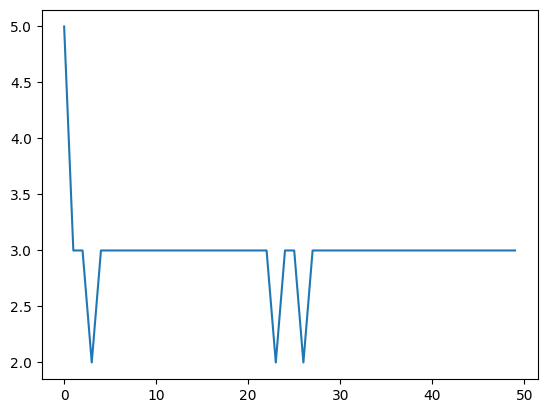

In [93]:
# 设置隐层大小为256 ，也是词嵌入维度      
hidden_size = 256
# 通过input_lang.n_words获取输入词汇总数，与hidden_size一同传入EncoderRNN类中
# 得到编码器对象encoder1
encoder1 = Encoder(input_lang.size, hidden_size).to(device)

# 通过output_lang.n_words获取目标词汇总数，与hidden_size和dropout_p一同传入AttnDecoderRNN类中
# 得到解码器对象attn_decoder1
attn_decoder1 = AttentionDecoder(hidden_size, output_lang.size, dropout=0.1).to(device)

# 设置迭代步数 
n_iters = 5000

# 调用trainIters进行模型训练，将编码器对象encoder1，码器对象attn_decoder1，迭代步数，日志打印间隔传入其中
trainIters(encoder1, attn_decoder1, n_iters)

In [102]:
# 构建评估函数
# 构建评估函数
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = TensorFormSentence(input_lang, sentence)
        # 获取句子长度
        input_length = input_tensor.size()[0]
        # 初始化编码器隐藏层张量
        input_hidden = encoder.init_hidden()
        # 初始化编码器输出张量
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
        
        # 循环遍历输入张量索引
        for ei in range(input_length):
            encoder_output, input_hidden = encoder(input_tensor[ei], input_hidden)
            # 将三维输出降低到一维,赋值给encoder_outputs
            encoder_outputs[ei] = encoder_output[0,0]
        
        # 初始化解码器
        decoder_input = torch.tensor([[SOS_TOKEN]], device=device)
        # 解码器隐藏层
        decoder_hidden = decoder.init_hidden()
        # 初始化预测词汇列表
        decoder_words = []
        # 初始化attention张量,用来画图
        decoder_attentions = torch.zeros(max_length, max_length)
        # 遍历解码器
        for di in range(max_length):
            # 将张量送入解码器
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            # 将注意力张量保存
            decoder_attentions[di] = decoder_attention.data
            # 按照最大概率来估值
            topv, topi = decoder_output.topk(1)
            if topi.item() == EOS_TOKEN:
                decoder_words.append('<EOS>')
                break
            else:
                # 添加预测的法文
                decoder_words.append(output_lang.index2word[topi.item()])
            # 将最后一步的预测标签作为下一步单独输入, topi是三维,要减低维度
            decoder_input = topi.squeeze().detach()
        return decoder_words, decoder_attentions[:di+1]

In [103]:
# 随机选择一个文本对进行调用
def evaluateRandomly(encoder, decoder, n=6):
    for i in range(n):
        # 随机选择语言对
        pair = random.choice(pairs)
        # 打印输入
        print('输入>', pair[0])
        # 打印输出
        print('输出>', pair[1])
        # 调用evaluate预测
        output_words, output_attn = evaluate(encoder,decoder,pair[0])
        output_sentence = ' '.join(output_words)
        print('预测结果>',output_sentence)
        print('')
        
evaluateRandomly(encoder1,attn_decoder1)

输入> they re asian .
输出> ils sont asiatiques .
预测结果> je suis suis tres <EOS>

输入> i m hardworking .
输出> je suis appliquee .
预测结果> je suis suis suis tres <EOS>

输入> i m at the end of my rope .
输出> pour moi c est la fin des haricots .
预测结果> je suis suis suis tres <EOS>

输入> i m declaring an emergency .
输出> je lance un signal de detresse .
预测结果> je suis suis suis tres <EOS>

输入> you re very religious aren t you ?
输出> vous etes tres religieux n est ce pas ?
预测结果> je suis suis suis tres <EOS>

输入> they re boring .
输出> elles sont ennuyeuses .
预测结果> je suis suis suis tres <EOS>


['je', 'suis', 'suis', 'suis', 'tres', '<EOS>']


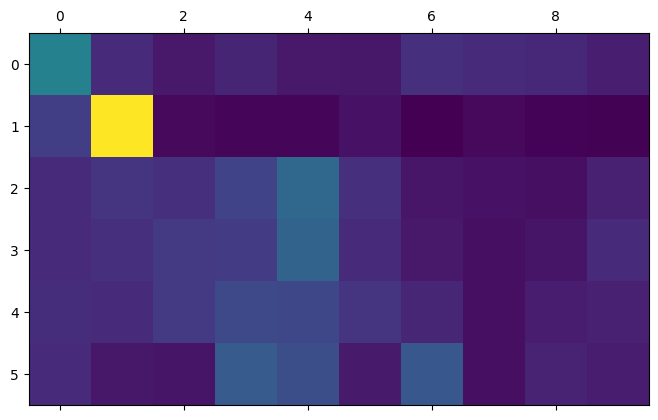

In [104]:
# Attention张量制图
sentence = "we re both teachers ."
# 调用评估函数
output_words, attentions = evaluate(
encoder1, attn_decoder1, sentence)
print(output_words)
# 将attention张量转化成numpy, 使用matshow绘制
plt.matshow(attentions.numpy())